In [110]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../")
import torch
import numpy as np

import defmod as dm
import defmod.multimodule_usefulfunctions as mm 
import matplotlib.pyplot as plt
import defmod.hamiltonian_multishape as hamiltonian
import defmod.model_graddesc as model
import defmod.save_results as results
import defmod.optimize as optimize


torch.set_default_tensor_type(torch.DoubleTensor)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [142]:
nb_pts1 = 20
nb_pts2 = 10
dim = 2

o1 = torch.tensor([0.,-1.])
o2 = torch.tensor([4.,3.])
origin = [o1,o2]
r1 = 2
r2 = 1
radius = [r1, r2]
nb_pts = [nb_pts1, nb_pts2]
source = mm.multipleCircles(origin, radius, nb_pts)

origin_target = [[0.,2.], [4.,-1.]]

target = mm.multipleCircles(origin_target, radius, nb_pts)


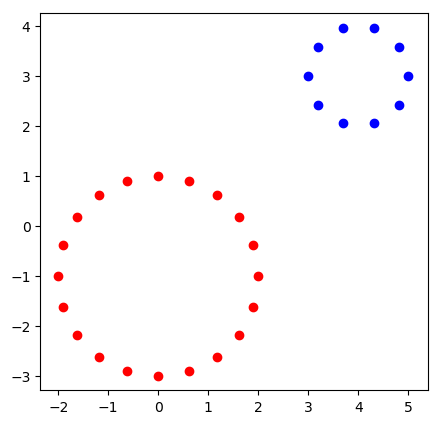

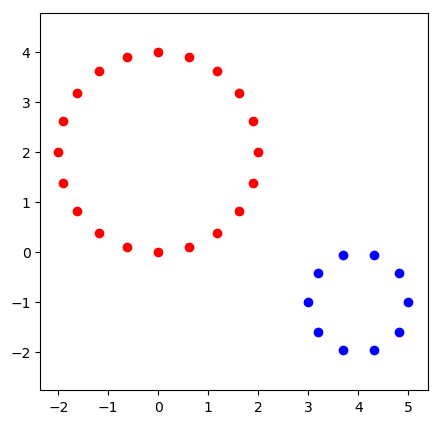

In [143]:
figsize = (5,5)
dpi = 100

fig_source = plt.figure(figsize=figsize, dpi=100)
plt.scatter(source[0][:, 0].detach().numpy(), source[0][:, 1].detach().numpy(), c='red')
plt.scatter(source[1][:, 0].detach().numpy(), source[1][:, 1].detach().numpy(), c='blue')
plt.axis('equal')

fig_target = plt.figure(figsize=figsize, dpi=100)
plt.scatter(target[0][:, 0].detach().numpy(), target[0][:, 1].detach().numpy(), c='red')
plt.scatter(target[1][:, 0].detach().numpy(), target[1][:, 1].detach().numpy(), c='blue')

plt.axis('equal')
plt.show()

In [183]:
# Defining the deformation modules
sigma1 = 20.
manifold1 = dm.manifold.Landmarks(dim, nb_pts1, gd=source[0].view(-1))
#trans1 = dm.deformationmodules.GlobalTranslation(manifold1, sigma1)
#trans1 = dm.deformationmodules.Translations(dm.manifold.Landmarks(2,1,gd=origin[0].view(-1).requires_grad_()), sigma1)
trans1 = dm.deformationmodules.Translations(manifold1, 5)

silent1 = dm.deformationmodules.SilentPoints(manifold1.copy())

mod1 = dm.deformationmodules.CompoundModule([silent1, trans1])

sigma2 = 20.
manifold2 = dm.manifold.Landmarks(dim, nb_pts2, gd=source[1].view(-1))
trans2 = dm.deformationmodules.GlobalTranslation(manifold2, sigma2)
silent2 = dm.deformationmodules.SilentPoints(manifold2.copy())

mod2 = dm.deformationmodules.CompoundModule([silent2, trans2])

module_list = [mod1, mod2]
sigma_bg = 0.5
modules = dm.multishape.MultiShapeModule(module_list, sigma_bg)

In [184]:
constr_Id = dm.constraints.Identity_Silent()
H = hamiltonian.Hamiltonian_multi(modules, constr_Id)

In [185]:
H = dm.hamiltonian.Hamiltonian(modules.module_list[0])

In [176]:

H.module.manifold[0][1].fill_cotan(torch.rand_like(H.module.manifold[0][1].cotan))
H.geodesic_controls()
constr_Id(H.module)

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ = torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), self.__coeff * K_q)


AttributeError: 'CompoundStructuredField' object has no attribute 'fieldlist'

In [177]:
def test_gradcheck_Hamiltonian():
    def hamiltonian(gd, mom):
        
        h.module.manifold.fill_gd(gd)
        h.module.manifold.fill_cotan(mom)
        h.geodesic_controls()
        return h()
    
    return torch.autograd.gradcheck(hamiltonian, (gd, mom), raise_exception=True)

h = H
gd0_tensor = torch.cat(h.module.manifold.unroll_gd().copy(),0).requires_grad_().view(-1)
gd = gd0_tensor
mom = 1000*torch.rand(gd.shape)


test_gradcheck_Hamiltonian()

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ = torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), self.__coeff * K_q)


RuntimeError: Jacobian mismatch for output 0 with respect to input 0,
numerical:tensor([[-9.6564e+05],
        [-2.0497e+03],
        [-1.7876e+06],
        [-5.9231e+05],
        [-1.4625e+06],
        [-1.0624e+06],
        [-1.2305e+06],
        [-1.6418e+06],
        [-3.6629e+04],
        [-1.1276e+05],
        [-3.4997e+02],
        [-2.7285e+05],
        [ 5.0437e+05],
        [-1.6594e+06],
        [ 9.3304e+05],
        [-1.3351e+06],
        [ 2.0418e+06],
        [-1.5333e+06],
        [ 2.0627e+06],
        [-7.0383e+05],
        [ 8.4893e+05],
        [-1.6910e+04],
        [ 2.0390e+06],
        [ 6.5861e+05],
        [ 1.3625e+06],
        [ 1.0051e+06],
        [ 6.8709e+05],
        [ 9.8778e+05],
        [ 4.1604e+05],
        [ 1.3104e+06],
        [-4.3121e+04],
        [ 2.5632e+06],
        [-3.8455e+05],
        [ 1.1485e+06],
        [-4.0170e+05],
        [ 5.3771e+05],
        [-1.2739e+06],
        [ 8.9981e+05],
        [-1.5245e+06],
        [ 4.8111e+05],
        [-1.3234e+06],
        [-2.1737e+04],
        [-1.5395e+06],
        [-5.1959e+05],
        [-2.1347e+06],
        [-1.5533e+06],
        [-8.2523e+05],
        [-1.1404e+06],
        [-5.5088e+05],
        [-1.5709e+06],
        [-3.6859e+04],
        [-1.6763e+06],
        [ 6.4853e+05],
        [-2.1108e+06],
        [ 8.2283e+05],
        [-1.1763e+06],
        [ 1.9127e+06],
        [-1.4349e+06],
        [ 1.1566e+06],
        [-3.9276e+05],
        [ 9.1495e+05],
        [-1.4483e+03],
        [ 5.8607e+05],
        [ 1.9116e+05],
        [ 1.7255e+06],
        [ 1.2560e+06],
        [ 1.2145e+06],
        [ 1.7067e+06],
        [ 6.9895e+05],
        [ 2.2451e+06],
        [-2.5676e+04],
        [ 1.3708e+06],
        [-3.0878e+05],
        [ 8.7833e+05],
        [-1.0823e+06],
        [ 1.4431e+06],
        [-1.7992e+06],
        [ 1.2703e+06],
        [-1.8384e+06],
        [ 5.7781e+05]])
analytical:tensor([[-9.6564e+05],
        [-2.0498e+03],
        [-1.7876e+06],
        [-5.9231e+05],
        [-1.4625e+06],
        [-1.0624e+06],
        [-1.2305e+06],
        [-1.6418e+06],
        [-3.6629e+04],
        [-1.1276e+05],
        [-3.5004e+02],
        [-2.7285e+05],
        [ 5.0437e+05],
        [-1.6594e+06],
        [ 9.3304e+05],
        [-1.3351e+06],
        [ 2.0418e+06],
        [-1.5333e+06],
        [ 2.0627e+06],
        [-7.0383e+05],
        [ 8.4893e+05],
        [-1.6910e+04],
        [ 2.0390e+06],
        [ 6.5861e+05],
        [ 1.3625e+06],
        [ 1.0051e+06],
        [ 6.8709e+05],
        [ 9.8778e+05],
        [ 4.1604e+05],
        [ 1.3104e+06],
        [-4.3121e+04],
        [ 2.5632e+06],
        [-3.8455e+05],
        [ 1.1485e+06],
        [-4.0170e+05],
        [ 5.3771e+05],
        [-1.2739e+06],
        [ 8.9981e+05],
        [-1.5245e+06],
        [ 4.8111e+05],
        [-1.3234e+06],
        [-2.1904e+04],
        [-1.5395e+06],
        [-5.1959e+05],
        [-2.1347e+06],
        [-1.5533e+06],
        [-8.2523e+05],
        [-1.1404e+06],
        [-5.5088e+05],
        [-1.5709e+06],
        [-3.6856e+04],
        [-1.6763e+06],
        [ 6.4853e+05],
        [-2.1108e+06],
        [ 8.2284e+05],
        [-1.1763e+06],
        [ 1.9127e+06],
        [-1.4349e+06],
        [ 1.1566e+06],
        [-3.9275e+05],
        [ 9.1495e+05],
        [-1.4484e+03],
        [ 5.8607e+05],
        [ 1.9123e+05],
        [ 1.7255e+06],
        [ 1.2560e+06],
        [ 1.2145e+06],
        [ 1.7067e+06],
        [ 6.9895e+05],
        [ 2.2451e+06],
        [-2.5676e+04],
        [ 1.3708e+06],
        [-3.0878e+05],
        [ 8.7833e+05],
        [-1.0823e+06],
        [ 1.4431e+06],
        [-1.7994e+06],
        [ 1.2703e+06],
        [-1.8384e+06],
        [ 5.7780e+05]])


In [186]:
# set parameters
reg_param = 10**-3

gd0_tensor = torch.cat(H.module.manifold.unroll_gd(),0).requires_grad_().view(-1)
mom0_tensor = torch.zeros(gd0_tensor.shape).requires_grad_().view(-1)
gd0_tensor.retain_grad()
mom0_tensor.retain_grad()
    
from defmod.attachement import L2NormAttachement
def attach(modules, target):
    return sum([L2NormAttachement()( modules.module_list[i][0].manifold.gd, target[i]) for i in range(len(target))])
    
E = model.EnergyFunctional(modules, H, constr_Id, source, target, dim, reg_param, attach=attach)

X = [gd0_tensor, mom0_tensor]

In [187]:
import defmod.optimize as optimize

In [188]:
X[1] = optimize.BFGS(E, X, disp=True)(maxiter=5000)

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ = torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), self.__coeff * K_q)


cost: 0.0 attach: 26.06551850567226
cost: 0.0 attach: 26.06551850567226
cost: 0.01747752546742218 attach: 23.660437048760016
cost: 0.01747752546742218 attach: 23.660437048760016
cost: 0.004406912068400672 attach: 13.781630222445607
cost: 0.004406912068400672 attach: 13.781630222445607
cost: 0.009862211459549955 attach: 17.603469787295516
cost: 0.009862211459549955 attach: 17.603469787295516
cost: 0.00531831283247222 attach: 12.78404029867349
cost: 0.00531831283247222 attach: 12.78404029867349
cost: 0.003362404719629583 attach: 17.00714158697138
cost: 0.003362404719629583 attach: 17.00714158697138
cost: 0.004885927592936876 attach: 13.129214450911078
cost: 0.004885927592936876 attach: 13.129214450911078
cost: 0.005228402664844092 attach: 12.717944949157515
cost: 0.005228402664844092 attach: 12.717944949157515
cost: 0.005207193760576867 attach: 12.74883181370429
cost: 0.005207193760576867 attach: 12.74883181370429
cost: 0.0052189959214329505 attach: 12.683857734850394
cost: 0.00521899592

cost: 0.005244583308510935 attach: 12.649110695373002
cost: 0.005244583308510935 attach: 12.649110695373002
cost: 0.005244583314137986 attach: 12.649110691978374
cost: 0.005244583314137986 attach: 12.649110691978374
cost: 0.005244583311858675 attach: 12.649110687058919
cost: 0.005244583311858675 attach: 12.649110687058919
cost: 0.005244583307795171 attach: 12.649110680895841
cost: 0.005244583307795171 attach: 12.649110680895841
cost: 0.005244583305124439 attach: 12.649110674747067
cost: 0.005244583305124439 attach: 12.649110674747067
cost: 0.005244583304107034 attach: 12.649110673088288
cost: 0.005244583304107034 attach: 12.649110673088288
cost: 0.005244583304393985 attach: 12.649110669990751
cost: 0.005244583304393985 attach: 12.649110669990751
cost: 0.005244583304721535 attach: 12.649110664415401
cost: 0.005244583304721535 attach: 12.649110664415401
cost: 0.005244583310808087 attach: 12.649110656532436
cost: 0.005244583310808087 attach: 12.649110656532436
cost: 0.00524458331352551 at

cost: 0.005244583311511646 attach: 12.649110640924746
cost: 0.005244583311511646 attach: 12.649110640924746
cost: 0.005244583311511638 attach: 12.649110640923993
cost: 0.005244583311511638 attach: 12.649110640923993
cost: 0.005244583311511638 attach: 12.649110640923993
cost: 0.005244583311511638 attach: 12.649110640923993
cost: 0.005244583311511645 attach: 12.649110640924745
cost: 0.005244583311511645 attach: 12.649110640924745
cost: 0.005244583311511638 attach: 12.649110640923993
cost: 0.005244583311511638 attach: 12.649110640923993
cost: 0.005244583311511638 attach: 12.649110640923993
cost: 0.005244583311511638 attach: 12.649110640923993
cost: 0.0052445833115116495 attach: 12.649110640924734
cost: 0.0052445833115116495 attach: 12.649110640924734
cost: 0.005244583311511638 attach: 12.649110640923993
cost: 0.005244583311511638 attach: 12.649110640923993
cost: 0.005244583311511638 attach: 12.649110640923993
cost: 0.005244583311511638 attach: 12.649110640923993
cost: 0.005244583311511648

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ = torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), self.__coeff * K_q)


cost: 0.005244583311512733 attach: 12.649110640927137
cost: 0.005244583311511891 attach: 12.64911064092443
cost: 0.005244583311511723 attach: 12.649110640924139
cost: 0.005244583311511663 attach: 12.649110640924714
cost: 0.005244583311511656 attach: 12.649110640924732
cost: 0.00524458331151166 attach: 12.649110640924738
cost: 0.00524458331151165 attach: 12.649110640924741
cost: 0.00524458331151165 attach: 12.649110640924759
cost: 0.005244583311511677 attach: 12.649110640924752
cost: 0.005244583311511644 attach: 12.649110640924755
cost: 0.005244583311511647 attach: 12.649110640924745
cost: 0.005244583311511649 attach: 12.649110640924693
         Current function value: 12.654355
         Iterations: 85
         Function evaluations: 219
         Gradient evaluations: 207


In [189]:
import defmod.save_res as results


In [190]:
H.module.manifold.fill_gd(X[0])
H.module.manifold.fill_cotan(X[1])
H.geodesic_controls()
print(torch.norm(constr_Id(H.module)))
save = results.Save_Results_MultiShape(H, source, target)

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ = torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), self.__coeff * K_q)


AttributeError: 'CompoundStructuredField' object has no attribute 'fieldlist'

In [ ]:
xlim = [-5, 10]
ylim = [-5,5]
d = [0.2, 0.2]
_ = save.gridpoints(xlim, ylim, d)

fig_states = save.fig_states(show=True)


In [191]:
fig_grid1, fig_grid2, fig_grid_bg, fig_multigrid = save.fig_grid(True)

AssertionError: 

In [ ]:
save.save('../results/circles_translation/MultiShapeDefmod/')
plt.close('all')

In [29]:
## LDDMM Module  -- sigma = sigma_bg

man_compound = dm.manifold.Landmarks(2, manifold1.nb_pts + manifold2.nb_pts, gd = torch.cat(source).view(-1))
module_LDDMM = dm.deformationmodules.CompoundModule([dm.deformationmodules.Translations(man_compound, sigma=0.5)])
H_LDDMM = dm.hamiltonian.Hamiltonian([module_LDDMM])

attach = dm.attachement.L2NormAttachement()
Energy_LDDMM = model.EnergyFunctional_unconstrained(module_LDDMM, H_LDDMM, [torch.cat(source)], [torch.cat(target)], dim=2, gamma=reg_param, attach=attach)
gd0 = torch.cat(module_LDDMM.manifold.unroll_gd())
mom0 = torch.cat(module_LDDMM.manifold.unroll_cotan())
X_LDDMM = [gd0, mom0]

X_LDDMM[1] = dm.optimize.BFGS(Energy_LDDMM, X_LDDMM, disp=True)(maxiter=250)

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ = torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), self.__coeff * K_q)


cost: 0.0 attach: 18.439088914585774
cost: 0.0 attach: 18.439088914585774
cost: 0.0010403282653804555 attach: 16.394755981693013
cost: 0.0010403282653804555 attach: 16.394755981693013
cost: 0.0260082066345114 attach: 9.868049788563592
cost: 0.0260082066345114 attach: 9.868049788563592
cost: 0.1790366818355769 attach: 13.479408765363049
cost: 0.1790366818355769 attach: 13.479408765363049
cost: 0.06340548142253857 attach: 7.440644358253178
cost: 0.06340548142253857 attach: 7.440644358253178
cost: 0.07430332946911708 attach: 6.537854222476336
cost: 0.07430332946911708 attach: 6.537854222476336
cost: 0.07078181957724516 attach: 5.407742440457253
cost: 0.07078181957724516 attach: 5.407742440457253
cost: 0.06034766008187499 attach: 4.456216929966611
cost: 0.06034766008187499 attach: 4.456216929966611
cost: 0.05923034266397664 attach: 7.521492025599624
cost: 0.05923034266397664 attach: 7.521492025599624
cost: 0.05889556178199467 attach: 4.072554407491576
cost: 0.05889556178199467 attach: 4.07

cost: 0.06909763678252173 attach: 0.8555623753848811
cost: 0.06909763678252173 attach: 0.8555623753848811
cost: 0.06837398271129767 attach: 0.8454828232593693
cost: 0.06837398271129767 attach: 0.8454828232593693
cost: 0.06710976665942474 attach: 0.8356988122700925
cost: 0.06710976665942474 attach: 0.8356988122700925
cost: 0.06668458592209221 attach: 0.8201422267539324
cost: 0.06668458592209221 attach: 0.8201422267539324
cost: 0.06559243516392152 attach: 0.8028380404527234
cost: 0.06559243516392152 attach: 0.8028380404527234
cost: 0.06388882240844883 attach: 0.8024461484688137
cost: 0.06388882240844883 attach: 0.8024461484688137
cost: 0.0648325381086022 attach: 0.7925684401619884
cost: 0.0648325381086022 attach: 0.7925684401619884
cost: 0.0643926549718542 attach: 0.777572835007007
cost: 0.0643926549718542 attach: 0.777572835007007
cost: 0.06327375569840825 attach: 0.7737844663178892
cost: 0.06327375569840825 attach: 0.7737844663178892
cost: 0.0638590909160817 attach: 0.7677046656865165


cost: 0.059467756916397406 attach: 0.17078023434457135
cost: 0.059467756916397406 attach: 0.17078023434457135
cost: 0.05947193976059506 attach: 0.17064286707427323
cost: 0.05947193976059506 attach: 0.17064286707427323
cost: 0.0594694996824381 attach: 0.17049808204134537
cost: 0.0594694996824381 attach: 0.17049808204134537
cost: 0.05947184755292488 attach: 0.17036228438163833
cost: 0.05947184755292488 attach: 0.17036228438163833
cost: 0.05947483047208803 attach: 0.17020184857874282
cost: 0.05947483047208803 attach: 0.17020184857874282
cost: 0.0594959106792759 attach: 0.17005187382449735
cost: 0.0594959106792759 attach: 0.17005187382449735
cost: 0.05950088129380776 attach: 0.16994466449199935
cost: 0.05950088129380776 attach: 0.16994466449199935
cost: 0.05952376361174368 attach: 0.16980386562333827
cost: 0.05952376361174368 attach: 0.16980386562333827
cost: 0.05953306009346605 attach: 0.16967981488209735
cost: 0.05953306009346605 attach: 0.16967981488209735
cost: 0.05955481774145166 atta

In [32]:
H_LDDMM.module.manifold.fill_gd(X_LDDMM[0])
H_LDDMM.module.manifold.fill_cotan(X_LDDMM[1])
H_LDDMM.geodesic_controls()
save = results.Save_Results_SingleShape(H_LDDMM, source, target)

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ = torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), self.__coeff * K_q)


../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ = torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), self.__coeff * K_q)


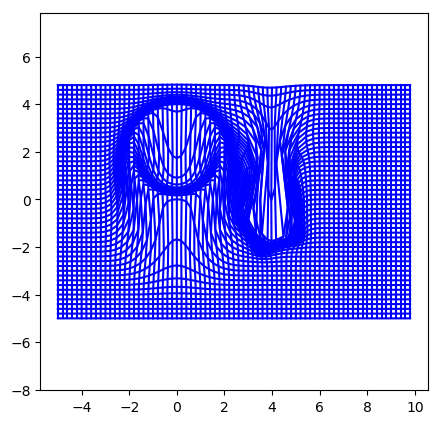

[<Figure size 500x500 with 1 Axes>]

In [33]:
xlim = [-5, 10]
ylim = [-5,5]
d = [0.2, 0.2]
_ = save.gridpoints(xlim, ylim, d)
save.fig_grid(True)

#save.save('../results/circles_translation/LDDMM_sigma0.5/')
#plt.close('all')

In [ ]:
## LDDMM Module  -- medium sigma 

man_compound = dm.manifold.Landmarks(2, manifold1.nb_pts + manifold2.nb_pts, gd = torch.cat(source).view(-1))
module_LDDMM = dm.deformationmodules.CompoundModule([dm.deformationmodules.Translations(man_compound, sigma=5)])
H_LDDMM = dm.hamiltonian.Hamiltonian([module_LDDMM])

attach = dm.attachement.L2NormAttachement()
Energy_LDDMM = model.EnergyFunctional_unconstrained(module_LDDMM, H_LDDMM, [torch.cat(source)], [torch.cat(target)], dim=2, gamma=reg_param, attach=attach)
gd0 = torch.cat(module_LDDMM.manifold.unroll_gd())
mom0 = torch.cat(module_LDDMM.manifold.unroll_cotan())
X_LDDMM = [gd0, mom0]

X_LDDMM[1] = dm.optimize.BFGS(Energy_LDDMM, X_LDDMM, disp=True)(maxiter=250)

H_LDDMM.module.manifold.fill_gd(X_LDDMM[0])
H_LDDMM.module.manifold.fill_cotan(X_LDDMM[1])
H_LDDMM.geodesic_controls()
save = results.Save_Results_SingleShape(H_LDDMM, source, target)

xlim = [-5, 10]
ylim = [-5,5]
d = [0.2, 0.2]
_ = save.gridpoints(xlim, ylim, d)
save.fig_grid(True)

save.save('../results/circles_translation/LDDMM_sigma5/')
plt.close('all')

In [40]:
## LDDMM Module  -- Big sigma 

man_compound = dm.manifold.Landmarks(2, manifold1.nb_pts + manifold2.nb_pts, gd = torch.cat(source).view(-1))
module_LDDMM = dm.deformationmodules.CompoundModule([dm.deformationmodules.Translations(man_compound, sigma=20)])
H_LDDMM = dm.hamiltonian.Hamiltonian([module_LDDMM])

attach = dm.attachement.L2NormAttachement()
Energy_LDDMM = model.EnergyFunctional_unconstrained(module_LDDMM, H_LDDMM, [torch.cat(source)], [torch.cat(target)], dim=2, gamma=reg_param, attach=attach)
gd0 = torch.cat(module_LDDMM.manifold.unroll_gd())
mom0 = torch.cat(module_LDDMM.manifold.unroll_cotan())
X_LDDMM = [gd0, mom0]

In [41]:
X_LDDMM[1] = dm.optimize.BFGS(Energy_LDDMM, X_LDDMM, disp=True)(maxiter=250)

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ = torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), self.__coeff * K_q)


cost: 0.0 attach: 18.439088914585774
cost: 0.0 attach: 18.439088914585774
cost: 0.014797844366882699 attach: 31.37993242195956
cost: 0.014797844366882699 attach: 31.37993242195956
cost: 0.0002071910886098972 attach: 18.052893356378476
cost: 0.0002071910886098972 attach: 18.052893356378476
cost: 0.00035313731533132155 attach: 17.729800322053087
cost: 0.00035313731533132155 attach: 17.729800322053087
cost: 0.003015625008325414 attach: 16.55564700792437
cost: 0.003015625008325414 attach: 16.55564700792437
cost: 0.02506739067048046 attach: 14.007725326441287
cost: 0.02506739067048046 attach: 14.007725326441287
cost: 0.11510562727487289 attach: 12.471004428196332
cost: 0.11510562727487289 attach: 12.471004428196332
cost: 0.18104960185106922 attach: 10.142549997793395
cost: 0.18104960185106922 attach: 10.142549997793395
cost: 0.2602604303970271 attach: 9.594742932746307
cost: 0.2602604303970271 attach: 9.594742932746307
cost: 0.24038858663329907 attach: 9.48827794652125
cost: 0.2403885866332

cost: 0.7777103445975886 attach: 6.0358147935021345
cost: 0.7777103445975886 attach: 6.0358147935021345
cost: 0.7820348636544996 attach: 6.031851810831918
cost: 0.7820348636544996 attach: 6.031851810831918
cost: 0.778080291469011 attach: 6.035431308979356
cost: 0.778080291469011 attach: 6.035431308979356
cost: 0.7779935425431745 attach: 6.035491302419399
cost: 0.7779935425431745 attach: 6.035491302419399
cost: 0.7776468845548037 attach: 6.035742713153329
cost: 0.7776468845548037 attach: 6.035742713153329
cost: 0.7772017873838434 attach: 6.035958532259297
cost: 0.7772017873838434 attach: 6.035958532259297
cost: 0.7767104695276575 attach: 6.036017133954189
cost: 0.7767104695276575 attach: 6.036017133954189
cost: 0.7759751576142528 attach: 6.035938900223459
cost: 0.7759751576142528 attach: 6.035938900223459
cost: 0.774880703098642 attach: 6.035522907530551
cost: 0.774880703098642 attach: 6.035522907530551
cost: 0.7733491217758713 attach: 6.034316297801128
cost: 0.7733491217758713 attach: 

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ = torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), self.__coeff * K_q)


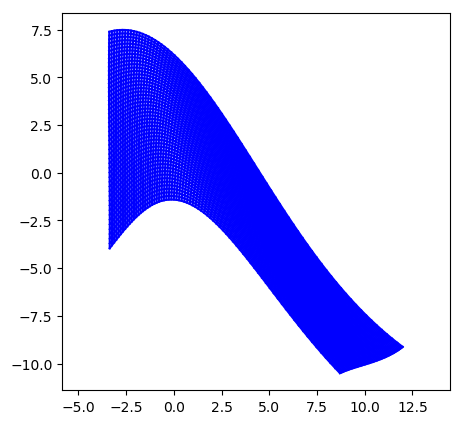

[<Figure size 500x500 with 1 Axes>]

In [42]:
H_LDDMM.module.manifold.fill_gd(X_LDDMM[0])
H_LDDMM.module.manifold.fill_cotan(X_LDDMM[1])
H_LDDMM.geodesic_controls()
save = results.Save_Results_SingleShape(H_LDDMM, source, target)

xlim = [-5, 10]
ylim = [-5,5]
d = [0.2, 0.2]
_ = save.gridpoints(xlim, ylim, d)
save.fig_grid(True)

save.save('../results/circles_translation/LDDMM_sigma20/')
plt.close('all')

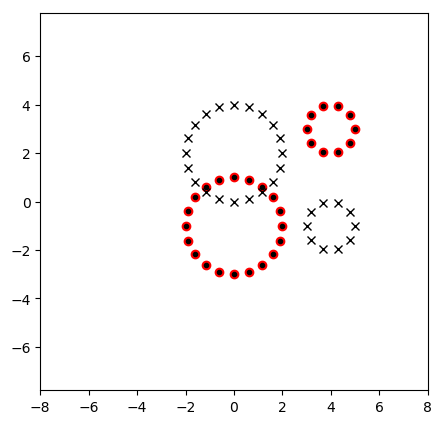

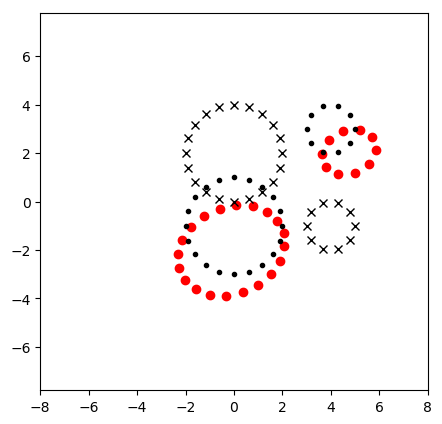

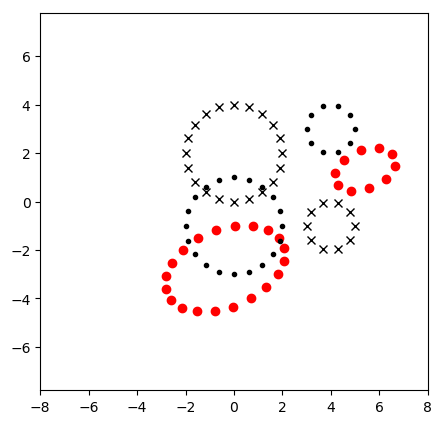

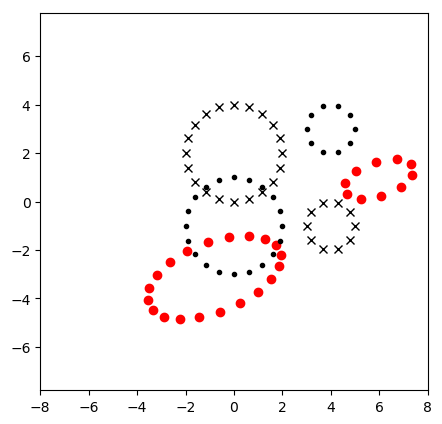

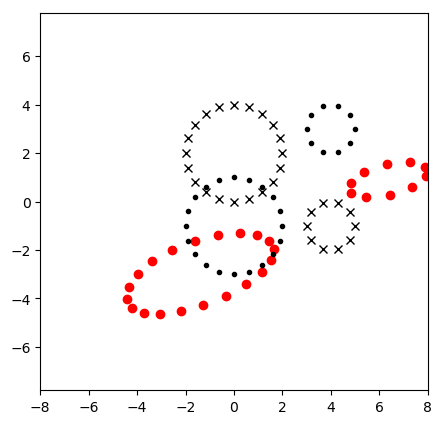

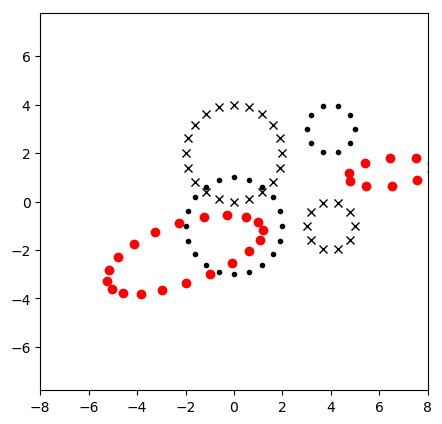

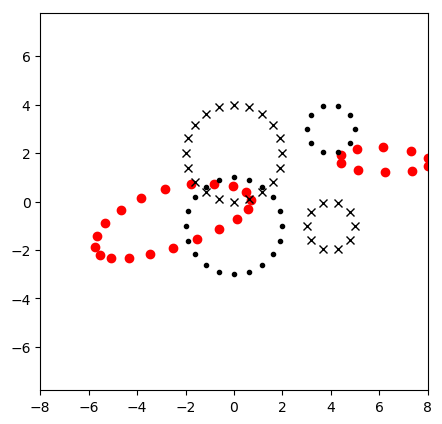

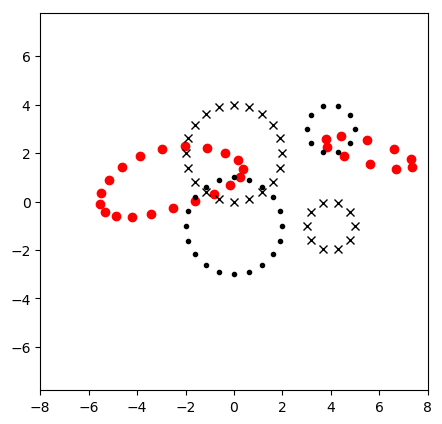

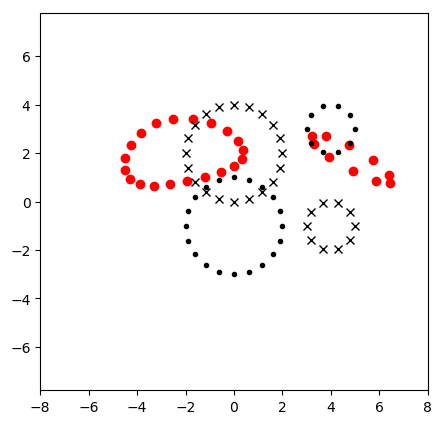

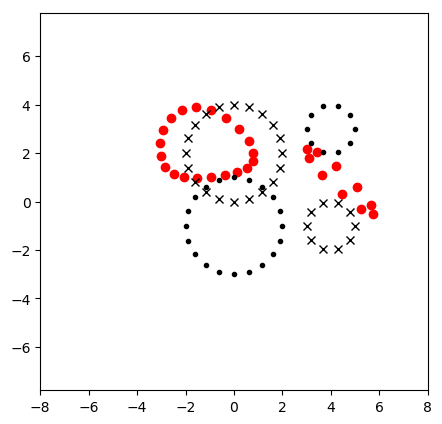

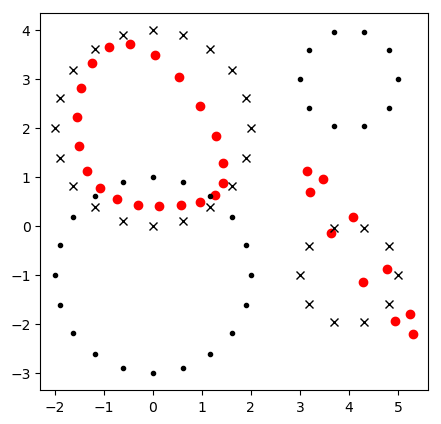

[<Figure size 500x500 with 1 Axes>,
 <Figure size 500x500 with 1 Axes>,
 <Figure size 500x500 with 1 Axes>,
 <Figure size 500x500 with 1 Axes>,
 <Figure size 500x500 with 1 Axes>,
 <Figure size 500x500 with 1 Axes>,
 <Figure size 500x500 with 1 Axes>,
 <Figure size 500x500 with 1 Axes>,
 <Figure size 500x500 with 1 Axes>,
 <Figure size 500x500 with 1 Axes>,
 <Figure size 500x500 with 1 Axes>]

In [57]:
save.fig_states(True, axeslim=[-8,8, -8,8])

In [136]:
## LDDMM Multishape Module
sigma1 = 1
manifold1 = dm.manifold.Landmarks(dim, nb_pts1, gd=source[0].view(-1))
trans1 = dm.deformationmodules.Translations(manifold1, sigma1)
silent1 = dm.deformationmodules.SilentPoints(manifold1.copy())

mod1 = dm.deformationmodules.CompoundModule([silent1, trans1])

sigma2 = 1
manifold2 = dm.manifold.Landmarks(dim, nb_pts2, gd=source[1].view(-1))
trans2 = dm.deformationmodules.Translations(manifold2, sigma2)
silent2 = dm.deformationmodules.SilentPoints(manifold2.copy())

mod2 = dm.deformationmodules.CompoundModule([silent2, trans2])

module_list = [mod1, mod2]
sigma_bg = 0.5
multi_LDDMM = dm.multishape.MultiShapeModule(module_list, sigma_bg)

constr = dm.constraints.Identity_Silent()
H_multi_LDDMM = dm.hamiltonian_multishape.Hamiltonian_multi(multi_LDDMM, constr)

In [137]:
def attach(modules, target):
    return sum([L2NormAttachement()( modules.module_list[i][1].manifold.gd, target[i]) for i in range(len(target))])
    
Energy_multi_LDDMM = model.EnergyFunctional(multi_LDDMM, H_multi_LDDMM, constr, source, target, dim=2, gamma=reg_param, attach = attach)
gd0 = torch.cat(multi_LDDMM.manifold.unroll_gd())
mom0 = torch.cat(multi_LDDMM.manifold.unroll_cotan())
X_multi_LDDMM = [gd0, mom0]


X_multi_LDDMM[1] = dm.optimize.BFGS(Energy_multi_LDDMM, X_multi_LDDMM, disp=True)(maxiter=20)

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ = torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), self.__coeff * K_q)


cost: 0.0 attach: 26.06551850567226
cost: 0.0 attach: 26.06551850567226
cost: 0.002129107025166718 attach: 22.650097114996832
cost: 0.002129107025166718 attach: 22.650097114996832
cost: 0.04893923370264571 attach: 12.649938878824756
cost: 0.04893923370264571 attach: 12.649938878824756
cost: 0.4361320927618593 attach: 18.03783565336311
cost: 0.4361320927618593 attach: 18.03783565336311
cost: 0.1172957223294299 attach: 8.864356108313297
cost: 0.1172957223294299 attach: 8.864356108313297
cost: 0.18519363486996793 attach: 8.806071209172392
cost: 0.18519363486996793 attach: 8.806071209172392
cost: 0.14623207714610362 attach: 7.39006413021421
cost: 0.14623207714610362 attach: 7.39006413021421
cost: 0.14539308160224948 attach: 5.868317761511891
cost: 0.14539308160224948 attach: 5.868317761511891
cost: 0.11134450110939635 attach: 4.981919523433441
cost: 0.11134450110939635 attach: 4.981919523433441
cost: 0.09274267405985197 attach: 2.6170835513082307
cost: 0.09274267405985197 attach: 2.6170835

In [138]:
H_multi_LDDMM.module.manifold.fill_gd(X_multi_LDDMM[0])
H_multi_LDDMM.module.manifold.fill_cotan(X_multi_LDDMM[1])
H_multi_LDDMM.geodesic_controls()
print(torch.norm(constr_Id(H_multi_LDDMM.module)))
save = results.Save_Results_MultiShape(H_multi_LDDMM, source, target)

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ = torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), self.__coeff * K_q)


tensor(1.2170e-12, grad_fn=<NormBackward0>)


../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ = torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), self.__coeff * K_q)
../defmod/multishape_silentpoints.py:221: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  lambda_qp,_ = torch.gesv(B, A)


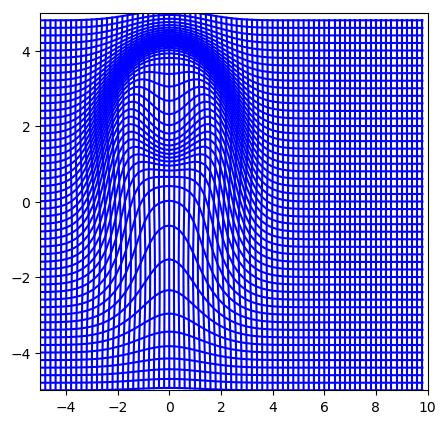

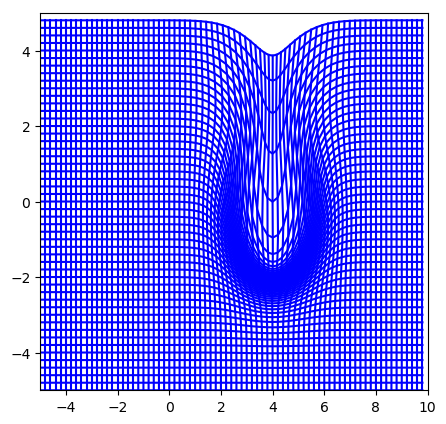

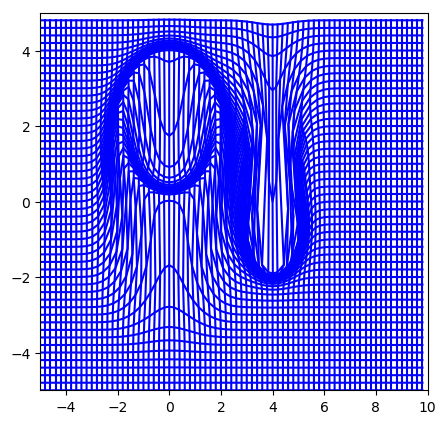

<Figure size 432x288 with 0 Axes>

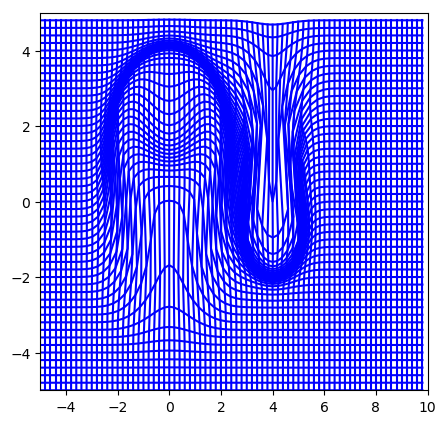

(<Figure size 500x500 with 1 Axes>,
 <Figure size 500x500 with 1 Axes>,
 <Figure size 500x500 with 1 Axes>,
 <Figure size 500x500 with 1 Axes>)

In [84]:
xlim = [-5, 10]
ylim = [-5,5]
d = [0.2, 0.2]
_ = save.gridpoints(xlim, ylim, d)
save.fig_grid(True)

#save.save('../results/circles_translation/MultiShapeLDDMM/')
#plt.close('all')

In [ ]:
## Unconstrained Compound Module

man_compound = dm.manifold.Landmarks(2, manifold1.nb_pts + manifold2.nb_pts, gd = torch.cat(source).view(-1))
trans1_comp = dm.deformationmodules.GlobalTranslation(manifold1, sigma = 5.)
trans1_comp.fill_controls_zero()
trans2_comp = dm.deformationmodules.GlobalTranslation(manifold2, sigma = 5.)
trans2_comp.fill_controls_zero()
trans_bg = dm.deformationmodules.Translations(man_compound, sigma=0.5)

module_compound = dm.deformationmodules.CompoundModule([trans1_comp, trans2_comp, trans_bg])
H_compound = dm.hamiltonian.Hamiltonian(module_compound)

attach = dm.attachement.L2NormAttachement()
Energy_compound = model.EnergyFunctional_unconstrained(module_compound, H_compound, source, target, dim=2, gamma=reg_param, attach=attach)
gd0_c = torch.cat(module_compound.manifold.unroll_gd())
mom0_c = torch.cat(module_compound.manifold.unroll_cotan())
X_compound = [gd0_c, mom0_c]

In [ ]:
X_compound[1] = dm.optimize.BFGS(Energy_compound, X_compound, disp=True)(maxiter=20)

In [ ]:
H_compound.module.manifold.fill_gd(X_compound[0])
H_compound.module.manifold.fill_cotan(X_compound[1])
H_compound.geodesic_controls()
save = results.Save_Results_SingleShape(H_compound, source, target)

In [ ]:
xlim = [-5, 10]
ylim = [-5,5]
d = [0.2, 0.2]
_ = save.gridpoints(xlim, ylim, d)
#fig = save.fig_grid(True)

save.save('../results/circles_translation/Compound/')
plt.close('all')

In [141]:
def test_gradcheck_Hamiltonian():
    def hamiltonian(gd, mom):
        
        h.module.manifold.fill_gd(gd)
        h.module.manifold.fill_cotan(mom)
        h.geodesic_controls()
        return h()
    
    return torch.autograd.gradcheck(hamiltonian, (gd, mom), raise_exception=True)

h = H
gd0_tensor = torch.cat(h.module.manifold.unroll_gd().copy(),0).requires_grad_().view(-1)
gd = gd0_tensor
mom = 1000*torch.rand(gd.shape)


test_gradcheck_Hamiltonian()

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ = torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), self.__coeff * K_q)


RuntimeError: Jacobian mismatch for output 0 with respect to input 0,
numerical:tensor([[ 6.4708e+11],
        [-8.3479e+11],
        [ 1.2024e+11],
        [-2.3954e+12],
        [ 3.3301e+11],
        [-4.0821e+11],
        [-5.5099e+11],
        [ 2.6400e+11],
        [-5.1329e+12],
        [ 1.7168e+12],
        [-4.1477e+12],
        [-3.2155e+12],
        [ 1.1432e+12],
        [-1.0307e+12],
        [ 9.5825e+11],
        [-1.8397e+12],
        [-4.3393e+11],
        [-7.6006e+11],
        [-5.5528e+11],
        [ 1.2560e+12],
        [ 4.5646e+11],
        [-1.0851e+12],
        [ 5.8721e+12],
        [-1.2857e+12],
        [ 1.5720e+11],
        [ 2.5583e+12],
        [-1.6062e+11],
        [-8.5109e+11],
        [ 1.2930e+12],
        [-6.8088e+12],
        [-1.2292e+13],
        [-1.9352e+12],
        [-4.2527e+11],
        [-8.2950e+11],
        [ 3.4158e+12],
        [-1.3177e+12],
        [ 8.5013e+10],
        [-4.6696e+11],
        [-4.6820e+12],
        [-2.1881e+12],
        [ 6.4228e+14],
        [ 9.0824e+13],
        [-2.9657e+13],
        [ 2.6231e+14],
        [-1.1711e+15],
        [-9.1110e+11],
        [ 3.7798e+13],
        [-9.2477e+13],
        [-2.5435e+16],
        [-1.2136e+14],
        [-7.0906e+14],
        [-1.6322e+14],
        [-1.5412e+15],
        [ 7.9038e+13],
        [-9.4359e+12],
        [-1.2679e+14],
        [ 9.7303e+12],
        [-3.1920e+13],
        [-2.4557e+13],
        [-3.5901e+14],
        [ 4.9508e+13],
        [-1.4688e+15],
        [-7.0778e+16],
        [-2.6556e+15],
        [ 4.4348e+13],
        [ 5.5025e+11],
        [ 1.1926e+14],
        [ 7.7805e+16],
        [ 1.1565e+14],
        [-7.9037e+14],
        [ 1.1315e+15],
        [ 2.6804e+14],
        [-7.8277e+14],
        [ 5.3923e+13],
        [-4.3258e+13],
        [ 1.4918e+15],
        [-4.3597e+13],
        [ 1.1800e+14],
        [-1.6662e+14],
        [ 2.9301e+13],
        [ 2.4535e+02],
        [ 0.0000e+00],
        [-4.6520e+03],
        [-3.3801e+03],
        [ 1.5536e+03],
        [ 4.7819e+03],
        [ 7.1129e+02],
        [-2.1895e+03],
        [-5.4762e+02],
        [ 3.9771e+02],
        [ 3.2855e+03],
        [ 0.0000e+00],
        [-4.6568e+02],
        [-3.3849e+02],
        [ 6.1885e+01],
        [ 1.9048e+02],
        [-7.4992e+02],
        [ 2.3084e+03],
        [ 2.0294e+03],
        [-1.4743e+03],
        [-5.2204e+03],
        [ 1.3104e+02],
        [-3.5767e+03],
        [-2.6839e+03],
        [-7.2418e+02],
        [-3.0149e+03],
        [ 2.0731e+03],
        [-5.3314e+03],
        [ 3.5508e+03],
        [-2.2319e+03],
        [ 1.0385e+03],
        [ 1.3107e+02],
        [ 3.5941e+03],
        [ 2.5257e+03],
        [ 1.5420e+03],
        [ 3.9593e+03],
        [-8.9219e+02],
        [ 3.7947e+03],
        [-2.8558e+03],
        [ 2.4224e+03],
        [-7.2200e+06],
        [ 1.2952e+07],
        [ 6.2611e+06],
        [-2.0266e+07],
        [-7.9478e+06],
        [ 1.0635e+07],
        [-1.3599e+07],
        [ 2.5970e+06],
        [ 5.7505e+06],
        [-5.4736e+06],
        [ 2.6254e+07],
        [-2.9045e+06],
        [-6.0140e+06],
        [ 5.1108e+06],
        [-9.5846e+06],
        [-1.1276e+07],
        [-2.4367e+05],
        [ 3.2166e+06],
        [ 4.7335e+06],
        [ 5.4230e+06],
        [-3.9305e+06],
        [ 8.1462e+06],
        [ 4.6054e+06],
        [-1.7627e+07],
        [-1.1194e+07],
        [ 1.7846e+07],
        [-6.1251e+06],
        [-6.3496e+06],
        [ 9.9649e+06],
        [-1.3940e+06],
        [ 1.5652e+07],
        [-4.6360e+06],
        [-2.6762e+06],
        [ 8.8285e+06],
        [ 5.6146e+06],
        [ 7.4661e+05],
        [-1.1024e+07],
        [ 3.8191e+06],
        [ 7.2398e+05],
        [-9.3943e+06],
        [-1.8702e+06],
        [-6.5565e-01],
        [-1.5130e+06],
        [-1.0993e+06],
        [-5.7792e+05],
        [-1.7787e+06],
        [ 5.7792e+05],
        [-1.7787e+06],
        [ 1.5130e+06],
        [-1.0993e+06],
        [ 1.8702e+06],
        [ 6.3479e+00],
        [ 1.5130e+06],
        [ 1.0992e+06],
        [ 5.7793e+05],
        [ 1.7787e+06],
        [-5.7792e+05],
        [ 1.7787e+06],
        [-1.5130e+06],
        [ 1.0993e+06]])
analytical:tensor([[ 4.9616e+05],
        [-5.6789e+04],
        [-9.8672e+04],
        [-1.6858e+04],
        [-3.2657e+05],
        [-7.4199e+04],
        [ 4.5039e+04],
        [-1.9266e+04],
        [ 1.4844e+05],
        [ 3.3417e+03],
        [ 2.0394e+05],
        [ 3.8015e+04],
        [-2.2345e+05],
        [-1.3576e+05],
        [ 1.2169e+05],
        [ 9.6168e+03],
        [-1.9048e+05],
        [-1.0531e+05],
        [-2.2771e+04],
        [-3.3648e+04],
        [-3.7464e+04],
        [ 3.6009e+04],
        [ 2.9446e+04],
        [ 2.5499e+04],
        [ 1.6409e+05],
        [-5.3213e+04],
        [-1.9726e+05],
        [ 3.0804e+05],
        [ 1.5605e+05],
        [-9.1556e+04],
        [-1.3358e+05],
        [ 2.4572e+05],
        [ 3.6504e+05],
        [-2.4266e+05],
        [-4.4057e+05],
        [ 2.7797e+05],
        [ 5.8106e+05],
        [-2.4469e+05],
        [-5.2309e+05],
        [ 1.3970e+05],
        [ 6.2408e+20],
        [ 1.6701e+21],
        [-6.5248e+20],
        [-1.6306e+21],
        [ 5.3224e+20],
        [ 5.0522e+20],
        [-1.8224e+21],
        [ 8.9672e+18],
        [ 2.5568e+21],
        [ 1.2169e+21],
        [-9.1875e+20],
        [-2.0760e+21],
        [-1.1540e+21],
        [ 8.1768e+20],
        [ 1.2490e+21],
        [ 8.1649e+20],
        [-2.8253e+20],
        [-7.8410e+20],
        [ 1.2837e+20],
        [-9.5273e+18],
        [-4.2523e+20],
        [ 1.0821e+20],
        [ 3.5776e+20],
        [ 6.1118e+19],
        [-6.2451e+20],
        [-3.9382e+20],
        [ 1.2839e+21],
        [ 2.2291e+21],
        [-7.7596e+20],
        [-4.9533e+21],
        [-7.8208e+20],
        [ 5.1711e+21],
        [ 7.5238e+20],
        [-1.7816e+21],
        [ 1.4657e+21],
        [-1.6996e+21],
        [-2.7253e+21],
        [ 2.3348e+21],
        [ 1.2129e+21],
        [-1.6111e+21],
        [ 2.4550e+02],
        [ 0.0000e+00],
        [-4.6521e+03],
        [-3.3800e+03],
        [ 1.5537e+03],
        [ 4.7817e+03],
        [ 7.1141e+02],
        [-2.1895e+03],
        [-5.4759e+02],
        [ 3.9785e+02],
        [ 3.2854e+03],
        [ 0.0000e+00],
        [-4.6574e+02],
        [-3.3838e+02],
        [ 6.1873e+01],
        [ 1.9043e+02],
        [-7.5008e+02],
        [ 2.3085e+03],
        [ 2.0293e+03],
        [-1.4744e+03],
        [-5.2205e+03],
        [ 1.3129e+02],
        [-3.5767e+03],
        [-2.6839e+03],
        [-7.2419e+02],
        [-3.0149e+03],
        [ 2.0729e+03],
        [-5.3311e+03],
        [ 3.5507e+03],
        [-2.2319e+03],
        [ 1.0383e+03],
        [ 1.3129e+02],
        [ 3.5940e+03],
        [ 2.5259e+03],
        [ 1.5419e+03],
        [ 3.9594e+03],
        [-8.9232e+02],
        [ 3.7949e+03],
        [-2.8558e+03],
        [ 2.4227e+03],
        [-7.2200e+06],
        [ 1.2952e+07],
        [ 6.2611e+06],
        [-2.0266e+07],
        [-7.9478e+06],
        [ 1.0635e+07],
        [-1.3599e+07],
        [ 2.5970e+06],
        [ 5.7505e+06],
        [-5.4736e+06],
        [ 2.6254e+07],
        [-2.9045e+06],
        [-6.0140e+06],
        [ 5.1108e+06],
        [-9.5846e+06],
        [-1.1276e+07],
        [-2.4367e+05],
        [ 3.2166e+06],
        [ 4.7335e+06],
        [ 5.4230e+06],
        [-3.9305e+06],
        [ 8.1462e+06],
        [ 4.6054e+06],
        [-1.7627e+07],
        [-1.1194e+07],
        [ 1.7846e+07],
        [-6.1251e+06],
        [-6.3496e+06],
        [ 9.9649e+06],
        [-1.3940e+06],
        [ 1.5652e+07],
        [-4.6360e+06],
        [-2.6762e+06],
        [ 8.8285e+06],
        [ 5.6146e+06],
        [ 7.4661e+05],
        [-1.1024e+07],
        [ 3.8191e+06],
        [ 7.2398e+05],
        [-9.3943e+06],
        [-1.8702e+06],
        [-4.8773e-01],
        [-1.5130e+06],
        [-1.0993e+06],
        [-5.7792e+05],
        [-1.7787e+06],
        [ 5.7792e+05],
        [-1.7787e+06],
        [ 1.5130e+06],
        [-1.0993e+06],
        [ 1.8702e+06],
        [ 6.2106e+00],
        [ 1.5130e+06],
        [ 1.0992e+06],
        [ 5.7793e+05],
        [ 1.7787e+06],
        [-5.7792e+05],
        [ 1.7786e+06],
        [-1.5130e+06],
        [ 1.0993e+06]])


In [ ]:
def test_gradcheck_Hamiltonian():
    def hamiltonian(gd, mom):
        
        mod.manifold.fill_gd(gd)
        mod.manifold.fill_cotan(mom)
        #H.geodesic_controls()
        #return H()
        mod.compute_geodesic_control_from_self(mod.manifold)
        return mod.controls
    
    return torch.autograd.gradcheck(hamiltonian, (gd, mom), raise_exception=True)

mod = H.module.module_list[0].copy()

#gd0_tensor = torch.cat(mod.manifold.unroll_gd().copy(),0).requires_grad_().view(-1)
#gd = gd0_tensor
#mom = 1000*torch.rand(gd.shape)

gd = torch.cat(mod.manifold.gd).clone().requires_grad_()
mom = torch.cat(mod.manifold.cotan).clone().requires_grad_()


#test_gradcheck_Hamiltonian()

In [ ]:
# Defining the deformation modules
sigma1 = 20
manifold1 = dm.manifold.Landmarks(dim, nb_pts1, gd=source[0].view(-1))
trans1 = dm.deformationmodules.GlobalTranslation(manifold1, sigma1)
trans1.fill_controls_zero()
#trans1 = dm.deformationmodules.Translations(manifold1, sigma1)
silent1 = dm.deformationmodules.SilentPoints(manifold1.copy())
mod1 = dm.deformationmodules.CompoundModule([silent1, trans1])

sigma_scaling = 1.
a = torch.sqrt(torch.tensor(3.))
direc_scaling_pts = torch.tensor([[1., 0.], [-0.5 , 0.5* a],  [-0.5, -0.5* a]], requires_grad=True, dtype=torch.float64)
direc_scaling_vec =  torch.tensor([[1., 0.], [-0.5 , 0.5* a],  [-0.5, -0.5* a]], requires_grad=True, dtype=torch.float64)
def f(x):
    centre = x.view(1,2).repeat(3,1)
    return centre + 0.3 * sigma_scaling * direc_scaling_pts

def g(x):
    return direc_scaling_vec
scaling0 = dm.deformationmodules.ConstrainedTranslations(dm.manifold.Landmarks(2, 1, gd = torch.tensor([0.,0.]).view(-1).requires_grad_()), f, g, sigma_scaling)

man_scal = dm.manifold.Landmarks(2,1, gd=torch.tensor([0.,0.]).view(-1).requires_grad_())
scal = dm.deformationmodules.LocalScaling(man_scal, sigma=5.)
sigma2 = 20
manifold2 = dm.manifold.Landmarks(dim, nb_pts2, gd=source[1].view(-1))
trans2 = dm.deformationmodules.GlobalTranslation(manifold2, sigma2)
trans2.fill_controls_zero()
trans2 = dm.deformationmodules.Translations(manifold2, sigma2)
silent2 = dm.deformationmodules.SilentPoints(manifold2.copy())
mod2 = dm.deformationmodules.CompoundModule([silent2, trans2, scal])


module_list = [mod1, mod2]
sigma_bg = 5.
modules = dm.multishape.MultiShapeModule(module_list, sigma_bg)

constr_Id = dm.constraints.Identity_Silent()
H = hamiltonian.Hamiltonian_multi(modules, constr_Id)

In [ ]:
dty = torch.float64
gd0 = torch.tensor([-1., 0.], requires_grad=True, dtype=dty)
gd1 = torch.tensor([1., 0.], requires_grad=True, dtype=dty)

nb_pts = source[0].shape[0]
man_silent = dm.manifold.Landmarks(2, nb_pts, gd=source[0].view(-1).requires_grad_())
man_scal1 = dm.manifold.Landmarks(2,1,gd=gd0)
man_scal2 = dm.manifold.Landmarks(2,1,gd=gd1)

sigma_scaling = 1.
silent = dm.deformationmodules.SilentPoints(man_silent)
scal1 = dm.deformationmodules.LocalScaling(man_scal1, sigma = sigma_scaling)
scal2 = dm.deformationmodules.LocalScaling(man_scal2, sigma = sigma_scaling)
trans = dm.deformationmodules.Translations(dm.manifold.Landmarks(2,1,gd = torch.tensor([0.,0.]).view(-1).requires_grad_()), sigma=400, coeff=5.)

comp1 = dm.deformationmodules.CompoundModule([silent, scal1, scal2, trans])

modules = dm.multishape.MultiShapeModule([comp1], sigma_bg)
constr_Id = dm.constraints.Identity_Silent()
H = hamiltonian.Hamiltonian_multi(modules, constr_Id)

In [ ]:
def test_gradcheck():
    def fun(gd, mom):
        mod.manifold.fill_gd(gd)
        mod.manifold.fill_cotan(mom)
        mod.compute_geodesic_control_from_self(mod.manifold.copy(retain_grad=True))
        return mod.controls
    return torch.autograd.gradcheck(fun, (gd, mom), raise_exception=True)

mod = dm.deformationmodules.CompoundModule([silent1, trans1])
#h = hamiltonian.Hamiltonian_multi(dm.multishape.MultiShapeModule(modlist, sigma_bg), constr_Id)

gd = torch.cat(mod.manifold.gd.copy()).detach().requires_grad_()
mom = torch.cat(mod.manifold.cotan.copy()).detach().requires_grad_()

test_gradcheck()